In [1]:
# load packages

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image
from tqdm import tqdm
import numpy as np

import matplotlib.pyplot as plt
import imageio
import matplotlib.image as mpimg
from scipy import ndimage

In [2]:
# borrowed code in this cell from https://gist.github.com/jakevdp

def scatter_plot(latent_representations, labels):
    # create an N-bin discrete colormap from the specified input map
    def discrete_cmap(n, base_cmap=None):
        base = plt.cm.get_cmap(base_cmap)
        return base.from_list(base.name+str(n), base(np.linspace(0, 1, n)), n)

    plt.figure(figsize=(10, 10))
    plt.scatter(latent_representations[:, 0], latent_representations[:, 1], cmap=discrete_cmap(10, 'jet'), c=labels, edgecolors='black')
    plt.colorbar()
    plt.grid()
    plt.show()

def display_images_in_a_row(images, file_path='./tmp.png'):
    save_image(images.view(-1, 1, 28, 28), '{}'.format(file_path))
    plt.imshow(mpimg.imread('{}'.format(file_path)))

class Autoencoder_Trainer(object):
    def __init__(self, autoencoder_model, learning_rate=1e-3, path=''):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.init_dataset(path)
        self.model = autoencoder_model
        self.model.to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate, weight_decay=1e-5)

    def init_dataset(self, path=''):
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
        trainTransform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.1307,), (0.3081,))])
        trainset = torchvision.datasets.MNIST(root='{}/./data'.format(path), train=True, download=True, transform=transform)
        train_loader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=False, num_workers=4)
        valset = torchvision.datasets.MNIST(root='{}/./data'.format(path), train=False, download=True, transform=transform)
        val_loader = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=False, num_workers=4)

        self.train_loader = train_loader
        self.val_loader = val_loader
        self.valset = valset
        self.trainset = trainset

    def loss_function(self, recon_x, x):
        BCE = F.mse_loss(recon_x, x)
        return BCE
	
    def get_train_set(self):
        images = torch.vstack([ x for x, _ in self.train_loader])
        return images
        
    def get_val_set(self):
        images = torch.vstack([ x for x, _ in self.val_loader])
        return images
    
    def train(self, epoch):
        self.model.train()
        train_loss = 0
        for batch_idx, (data, _) in tqdm(enumerate(self.train_loader), total=len(self.train_loader)):
            data = data.to(self.device)
            self.optimizer.zero_grad()
            recon_batch = self.model(data)
            loss = self.loss_function(recon_batch, data)
            loss.backward()
            train_loss += loss.item()
            self.optimizer.step()

        BATCH_SIZE = 32
        train_loss /= len(self.train_loader.dataset) / BATCH_SIZE
        print(' ====> Epoch: {} Average loss: {:.4f}'.format(
              epoch, train_loss))

    def validate(self, epoch):
        self.model.eval()
        val_loss = 0
        with torch.no_grad():
            for i, (data, _) in tqdm(enumerate(self.val_loader), total=len(self.val_loader)):
                data = data.to(self.device)
                recon_batch = self.model(data)
                val_loss += self.loss_function(recon_batch, data).item()

        BATCH_SIZE = 32
        val_loss /= len(self.val_loader.dataset) / BATCH_SIZE
        print(' ====> Val set loss (reconstruction error) : {:.4f}'.format(val_loss))


## 784 x 2 x 784 Neurons

In [ ]:
class Autoencoder(nn.Module):

    def __init__(self, dim_latent_representation=2):

        super(Autoencoder, self).__init__()

        class Encoder(nn.Module):

            def __init__(self, output_size=2):
                super(Encoder, self).__init__()
                input_size = 784
                self.fc1 = nn.Linear(input_size, output_size)

            def forward(self, x):
                x = x.reshape(x.size(0), -1)
                return self.fc1(x)

        class Decoder(nn.Module):

            def __init__(self, input_size=2):
                super(Decoder, self).__init__()
                output_size = 784
                self.fc1 = nn.Linear(input_size, output_size)

            def forward(self, z):
                z = F.sigmoid(self.fc1(z))
                return z.reshape(z.size(0),1,28,28)

        self.encoder = Encoder(output_size=dim_latent_representation)
        self.decoder = Decoder(input_size=dim_latent_representation)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
# Tuned LEARNING_RATE with values: 1e-5, 1e-4, 1e-3, 1e-2, 1e-1
LEARNING_RATE = 1e-3
# Tuned EPOCH_NUMBER with integers: 1 to 12
EPOCH_NUMBER = 10

autoencoder = Autoencoder(dim_latent_representation=2)
trainer = Autoencoder_Trainer(autoencoder_model=autoencoder, learning_rate=LEARNING_RATE, path=path)

for epoch in range(1, EPOCH_NUMBER + 1):
    trainer.train(epoch)
    trainer.validate(epoch)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0%|          | 0/1875 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 1875/1875 [00:12<00:00, 155.90it/s]

====> Epoch: 1 Average loss: 0.8576



100%|██████████| 313/313 [00:01<00:00, 192.51it/s]

====> Val set loss (reconstruction error) : 0.8055



100%|██████████| 1875/1875 [00:11<00:00, 160.32it/s]

====> Epoch: 2 Average loss: 0.7769



100%|██████████| 313/313 [00:01<00:00, 188.58it/s]

====> Val set loss (reconstruction error) : 0.7665



100%|██████████| 1875/1875 [00:11<00:00, 157.30it/s]

====> Epoch: 3 Average loss: 0.7552



100%|██████████| 313/313 [00:01<00:00, 192.28it/s]

====> Val set loss (reconstruction error) : 0.7552



100%|██████████| 1875/1875 [00:12<00:00, 156.23it/s]

====> Epoch: 4 Average loss: 0.7444



100%|██████████| 313/313 [00:01<00:00, 182.04it/s]

====> Val set loss (reconstruction error) : 0.7472



100%|██████████| 1875/1875 [00:11<00:00, 157.93it/s]

====> Epoch: 5 Average loss: 0.7392



100%|██████████| 313/313 [00:01<00:00, 183.57it/s]

====> Val set loss (reconstruction error) : 0.7444



100%|██████████| 1875/1875 [00:11<00:00, 157.11it/s]

====> Epoch: 6 Average loss: 0.7368



100%|██████████| 313/313 [00:01<00:00, 183.64it/s]

====> Val set loss (reconstruction error) : 0.7420



100%|██████████| 1875/1875 [00:11<00:00, 157.89it/s]

====> Epoch: 7 Average loss: 0.7347



100%|██████████| 313/313 [00:01<00:00, 183.64it/s]

====> Val set loss (reconstruction error) : 0.7408



100%|██████████| 1875/1875 [00:11<00:00, 158.90it/s]

====> Epoch: 8 Average loss: 0.7337



100%|██████████| 313/313 [00:01<00:00, 189.56it/s]

====> Val set loss (reconstruction error) : 0.7399



100%|██████████| 1875/1875 [00:11<00:00, 157.51it/s]

====> Epoch: 9 Average loss: 0.7318



100%|██████████| 313/313 [00:01<00:00, 183.19it/s]

====> Val set loss (reconstruction error) : 0.7377



100%|██████████| 1875/1875 [00:12<00:00, 153.60it/s]

====> Epoch: 10 Average loss: 0.7303



100%|██████████| 313/313 [00:01<00:00, 184.73it/s]

====> Val set loss (reconstruction error) : 0.7370


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


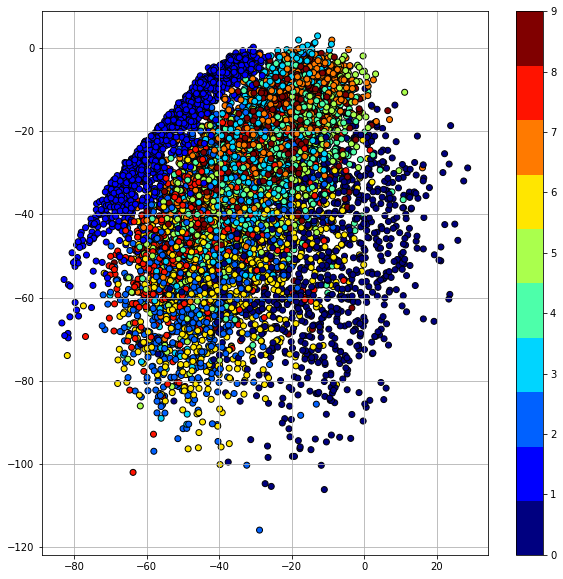

In [ ]:
# borrowed code in this cell from https://gist.github.com/jakevdp

with torch.no_grad():
    model = trainer.model
    model.eval()
    z = []
    label = []

    for x, y in trainer.val_loader:
        z_ = model.encoder(x.to(trainer.device))
        z += z_.cpu().tolist()
        label += y.cpu().tolist()

    z = np.asarray(z)
    label = np.asarray(label)

scatter_plot(latent_representations=z, labels=label)

## 784 x 1024 x 2 x 1024 x 784 Neurons

In [ ]:
class Autoencoder(nn.Module):

    def __init__(self, dim_latent_representation=2):

        super(Autoencoder, self).__init__()

        class Encoder(nn.Module):

            def __init__(self, output_size=2):
                super(Encoder, self).__init__()
                input_size = 784
                hidden_units = 1024
                self.fc1 = nn.Linear(input_size, hidden_units)
                self.fc2 = nn.Linear(hidden_units, output_size)

            def forward(self, x):
                x = x.reshape(x.size(0), -1)
                x = F.relu(self.fc1(x))
                return self.fc2(x)

        class Decoder(nn.Module):

            def __init__(self, input_size=2):
                super(Decoder, self).__init__()
                output_size = 784
                hidden_units = 1024
                self.fc1 = nn.Linear(input_size, hidden_units)
                self.fc2 = nn.Linear(hidden_units, output_size)

            def forward(self, z):
                z = F.relu(self.fc1(z))
                z = F.sigmoid(self.fc2(z))
                return z.reshape(z.size(0),1,28,28)

        self.encoder = Encoder(output_size=dim_latent_representation)
        self.decoder = Decoder(input_size=dim_latent_representation)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
# Tuned LEARNING_RATE with values: 1e-5, 1e-4, 1e-3, 1e-2, 1e-1
LEARNING_RATE = 1e-4
# Tuned EPOCH_NUMBER with integers: 1 to 12
EPOCH_NUMBER = 11

autoencoder = Autoencoder(dim_latent_representation=2)
trainer = Autoencoder_Trainer(autoencoder_model=autoencoder, learning_rate=LEARNING_RATE, path=path)

for epoch in range(1, EPOCH_NUMBER + 1):
    trainer.train(epoch)
    trainer.validate(epoch)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0%|          | 0/1875 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 1875/1875 [00:13<00:00, 141.25it/s]

====> Epoch: 1 Average loss: 0.7251



100%|██████████| 313/313 [00:01<00:00, 182.75it/s]

====> Val set loss (reconstruction error) : 0.7042



100%|██████████| 1875/1875 [00:13<00:00, 141.11it/s]

====> Epoch: 2 Average loss: 0.6910



100%|██████████| 313/313 [00:01<00:00, 172.56it/s]

====> Val set loss (reconstruction error) : 0.6914



100%|██████████| 1875/1875 [00:13<00:00, 141.60it/s]

====> Epoch: 3 Average loss: 0.6828



100%|██████████| 313/313 [00:01<00:00, 180.29it/s]

====> Val set loss (reconstruction error) : 0.6867



100%|██████████| 1875/1875 [00:13<00:00, 141.69it/s]

====> Epoch: 4 Average loss: 0.6785



100%|██████████| 313/313 [00:01<00:00, 181.81it/s]

====> Val set loss (reconstruction error) : 0.6830



100%|██████████| 1875/1875 [00:13<00:00, 143.88it/s]

====> Epoch: 5 Average loss: 0.6755



100%|██████████| 313/313 [00:01<00:00, 179.06it/s]

====> Val set loss (reconstruction error) : 0.6805



100%|██████████| 1875/1875 [00:13<00:00, 142.01it/s]

====> Epoch: 6 Average loss: 0.6730



100%|██████████| 313/313 [00:01<00:00, 182.32it/s]

====> Val set loss (reconstruction error) : 0.6782



100%|██████████| 1875/1875 [00:12<00:00, 145.42it/s]

====> Epoch: 7 Average loss: 0.6705



100%|██████████| 313/313 [00:01<00:00, 181.24it/s]

====> Val set loss (reconstruction error) : 0.6768



100%|██████████| 1875/1875 [00:13<00:00, 143.52it/s]

====> Epoch: 8 Average loss: 0.6685



100%|██████████| 313/313 [00:01<00:00, 184.09it/s]

====> Val set loss (reconstruction error) : 0.6756



100%|██████████| 1875/1875 [00:13<00:00, 143.07it/s]

====> Epoch: 9 Average loss: 0.6671



100%|██████████| 313/313 [00:01<00:00, 181.67it/s]

====> Val set loss (reconstruction error) : 0.6747



100%|██████████| 1875/1875 [00:13<00:00, 143.15it/s]

====> Epoch: 10 Average loss: 0.6660



100%|██████████| 313/313 [00:01<00:00, 185.76it/s]

====> Val set loss (reconstruction error) : 0.6733



100%|██████████| 1875/1875 [00:12<00:00, 144.56it/s]

====> Epoch: 11 Average loss: 0.6648



100%|██████████| 313/313 [00:01<00:00, 185.18it/s]

====> Val set loss (reconstruction error) : 0.6719


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


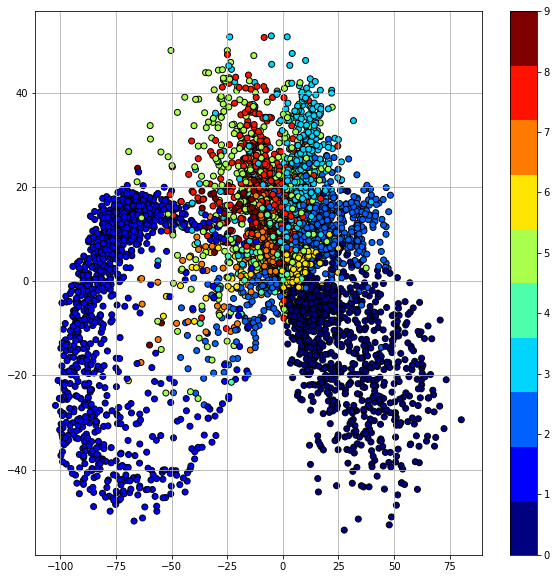

In [ ]:
# borrowed code in this cell from https://gist.github.com/jakevdp

with torch.no_grad():
    model = trainer.model
    model.eval()
    z = []
    label = []

    for x, y in trainer.val_loader:
        z_ = model.encoder(x.to(trainer.device))
        z += z_.cpu().tolist()
        label += y.cpu().tolist()

    z = np.asarray(z)
    label = np.asarray(label)

scatter_plot(latent_representations=z, labels=label)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Reconstructed images


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


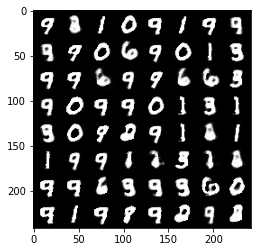

In [ ]:
images = trainer.get_val_set()
total_number = 64
images = images[:total_number]

with torch.no_grad():
    images = images.to(trainer.device)
    reconstructed = trainer.model(images).cpu()

print('Reconstructed images')
display_images_in_a_row(reconstructed)

## 784 x 1024 x 10 x 1024 x 784 Neurons

In [ ]:
  class Autoencoder(nn.Module):

      def __init__(self, dim_latent_representation=10):

          super(Autoencoder, self).__init__()

          class Encoder(nn.Module):

              def __init__(self, output_size=10):
                  super(Encoder, self).__init__()
                  input_size = 784
                  hidden_units = 1024
                  self.fc1 = nn.Linear(input_size, hidden_units)
                  self.fc2 = nn.Linear(hidden_units, output_size)

              def forward(self, x):
                  x = x.reshape(x.size(0), -1)
                  x = F.relu(self.fc1(x))
                  return self.fc2(x)

          class Decoder(nn.Module):

              def __init__(self, input_size=10):
                  super(Decoder, self).__init__()
                  output_size = 784
                  hidden_units = 1024
                  self.fc1 = nn.Linear(input_size, hidden_units)
                  self.fc2 = nn.Linear(hidden_units, output_size)

              def forward(self, z):
                  z = F.relu(self.fc1(z))
                  z = F.sigmoid(self.fc2(z))
                  return z.reshape(z.size(0),1,28,28)

          self.encoder = Encoder(output_size=dim_latent_representation)
          self.decoder = Decoder(input_size=dim_latent_representation)

      def forward(self, x):
          x = self.encoder(x)
          x = self.decoder(x)
          return x

In [ ]:
# Tuned LEARNING_RATE with values: 1e-5, 1e-4, 1e-3, 1e-2, 1e-1
LEARNING_RATE = 1e-3
# Tuned EPOCH_NUMBER with integers: 1 to 12
EPOCH_NUMBER = 12

autoencoder = Autoencoder(dim_latent_representation=10)
trainer = Autoencoder_Trainer(autoencoder_model=autoencoder, learning_rate=LEARNING_RATE, path=path)

for epoch in range(1, EPOCH_NUMBER + 1):
    trainer.train(epoch)
    trainer.validate(epoch)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0%|          | 0/1875 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 1875/1875 [00:13<00:00, 143.68it/s]

====> Epoch: 1 Average loss: 0.5759



100%|██████████| 313/313 [00:01<00:00, 184.88it/s]

====> Val set loss (reconstruction error) : 0.5630



100%|██████████| 1875/1875 [00:13<00:00, 142.64it/s]

====> Epoch: 2 Average loss: 0.5439



100%|██████████| 313/313 [00:01<00:00, 186.75it/s]

====> Val set loss (reconstruction error) : 0.5527



100%|██████████| 1875/1875 [00:13<00:00, 142.67it/s]

====> Epoch: 3 Average loss: 0.5374



100%|██████████| 313/313 [00:01<00:00, 180.16it/s]

====> Val set loss (reconstruction error) : 0.5490



100%|██████████| 1875/1875 [00:13<00:00, 143.52it/s]

====> Epoch: 4 Average loss: 0.5336



100%|██████████| 313/313 [00:01<00:00, 180.62it/s]

====> Val set loss (reconstruction error) : 0.5423



100%|██████████| 1875/1875 [00:13<00:00, 142.05it/s]

====> Epoch: 5 Average loss: 0.5309



100%|██████████| 313/313 [00:01<00:00, 187.76it/s]

====> Val set loss (reconstruction error) : 0.5410



100%|██████████| 1875/1875 [00:13<00:00, 142.47it/s]

====> Epoch: 6 Average loss: 0.5285



100%|██████████| 313/313 [00:01<00:00, 178.86it/s]

====> Val set loss (reconstruction error) : 0.5388



100%|██████████| 1875/1875 [00:13<00:00, 142.07it/s]

====> Epoch: 7 Average loss: 0.5269



100%|██████████| 313/313 [00:01<00:00, 186.33it/s]

====> Val set loss (reconstruction error) : 0.5375



100%|██████████| 1875/1875 [00:13<00:00, 142.49it/s]

====> Epoch: 8 Average loss: 0.5257



100%|██████████| 313/313 [00:01<00:00, 186.96it/s]

====> Val set loss (reconstruction error) : 0.5368



100%|██████████| 1875/1875 [00:13<00:00, 141.10it/s]

====> Epoch: 9 Average loss: 0.5249



100%|██████████| 313/313 [00:01<00:00, 182.06it/s]

====> Val set loss (reconstruction error) : 0.5368



100%|██████████| 1875/1875 [00:13<00:00, 140.61it/s]

====> Epoch: 10 Average loss: 0.5241



100%|██████████| 313/313 [00:01<00:00, 180.38it/s]

====> Val set loss (reconstruction error) : 0.5352



100%|██████████| 1875/1875 [00:13<00:00, 142.49it/s]

====> Epoch: 11 Average loss: 0.5234



100%|██████████| 313/313 [00:01<00:00, 182.70it/s]

====> Val set loss (reconstruction error) : 0.5340



100%|██████████| 1875/1875 [00:13<00:00, 139.96it/s]

====> Epoch: 12 Average loss: 0.5229



100%|██████████| 313/313 [00:01<00:00, 181.12it/s]

====> Val set loss (reconstruction error) : 0.5340


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Reconstructed images


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


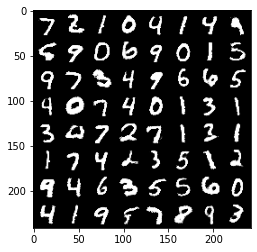

In [ ]:
images = trainer.get_val_set()
total_number = 64
images = images[:total_number]

with torch.no_grad():
    images = images.to(trainer.device)
    reconstructed = trainer.model(images).cpu()

print('Reconstructed images')
display_images_in_a_row(reconstructed)

## Interpolating Images

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Reconstructed images


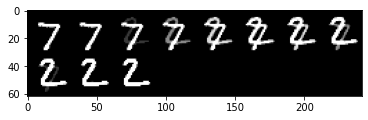

In [ ]:
LEARNING_RATE = 1e-3
EPOCH_NUMBER = 12

autoencoder = Autoencoder(dim_latent_representation=10)
trainer = Autoencoder_Trainer(autoencoder_model=autoencoder, learning_rate=LEARNING_RATE, path=path)

images = trainer.get_val_set()

with torch.no_grad():
    images = images.to()
    interpolated_images = None

    for i, t in enumerate(np.linspace(0, 1, 11)):
        image = torch.lerp(images1, images2, t)
        is_first_iteration = i == 0

        if is_first_iteration:
          interpolated_images = image
        else:
          interpolated_images = torch.cat((interpolated_images, image), 0)
    
    reconstructed = interpolated_images

print('Reconstructed images')
display_images_in_a_row(reconstructed)

## Morphing images using the (784 x 1024 x 2 x 1024 x 784) Autoencoder

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0%|          | 0/1875 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 1875/1875 [00:12<00:00, 145.91it/s]

====> Epoch: 1 Average loss: 0.7232



100%|██████████| 313/313 [00:01<00:00, 178.44it/s]

====> Val set loss (reconstruction error) : 0.7024



100%|██████████| 1875/1875 [00:13<00:00, 143.06it/s]

====> Epoch: 2 Average loss: 0.6903



100%|██████████| 313/313 [00:01<00:00, 177.78it/s]

====> Val set loss (reconstruction error) : 0.6905



100%|██████████| 1875/1875 [00:12<00:00, 144.86it/s]

====> Epoch: 3 Average loss: 0.6832



100%|██████████| 313/313 [00:01<00:00, 182.48it/s]

====> Val set loss (reconstruction error) : 0.6864



100%|██████████| 1875/1875 [00:13<00:00, 143.37it/s]

====> Epoch: 4 Average loss: 0.6797



100%|██████████| 313/313 [00:01<00:00, 184.05it/s]

====> Val set loss (reconstruction error) : 0.6838



100%|██████████| 1875/1875 [00:12<00:00, 144.68it/s]

====> Epoch: 5 Average loss: 0.6766



100%|██████████| 313/313 [00:01<00:00, 183.24it/s]

====> Val set loss (reconstruction error) : 0.6812



100%|██████████| 1875/1875 [00:12<00:00, 145.77it/s]

====> Epoch: 6 Average loss: 0.6743



100%|██████████| 313/313 [00:01<00:00, 187.21it/s]

====> Val set loss (reconstruction error) : 0.6793



100%|██████████| 1875/1875 [00:12<00:00, 145.67it/s]

====> Epoch: 7 Average loss: 0.6724



100%|██████████| 313/313 [00:01<00:00, 187.25it/s]

====> Val set loss (reconstruction error) : 0.6784



100%|██████████| 1875/1875 [00:12<00:00, 146.94it/s]

====> Epoch: 8 Average loss: 0.6709



100%|██████████| 313/313 [00:01<00:00, 176.01it/s]

====> Val set loss (reconstruction error) : 0.6771



100%|██████████| 1875/1875 [00:13<00:00, 141.92it/s]

====> Epoch: 9 Average loss: 0.6695



100%|██████████| 313/313 [00:01<00:00, 185.50it/s]

====> Val set loss (reconstruction error) : 0.6759



100%|██████████| 1875/1875 [00:13<00:00, 143.75it/s]

====> Epoch: 10 Average loss: 0.6678



100%|██████████| 313/313 [00:01<00:00, 181.76it/s]

====> Val set loss (reconstruction error) : 0.6744



100%|██████████| 1875/1875 [00:12<00:00, 146.57it/s]

====> Epoch: 11 Average loss: 0.6666



100%|██████████| 313/313 [00:01<00:00, 185.44it/s]

====> Val set loss (reconstruction error) : 0.6729


Reconstructed images


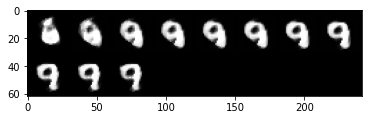

In [ ]:
class Autoencoder(nn.Module):

    def __init__(self, dim_latent_representation=2):

        super(Autoencoder, self).__init__()

        class Encoder(nn.Module):

            def __init__(self, output_size=2):
                super(Encoder, self).__init__()
                input_size = 784
                hidden_units = 1024
                self.fc1 = nn.Linear(input_size, hidden_units)
                self.fc2 = nn.Linear(hidden_units, output_size)

            def forward(self, x):
                x = x.reshape(x.size(0), -1)
                x = F.relu(self.fc1(x))
                return self.fc2(x)

        class Decoder(nn.Module):

            def __init__(self, input_size=2):
                super(Decoder, self).__init__()
                output_size = 784
                hidden_units = 1024
                self.fc1 = nn.Linear(input_size, hidden_units)
                self.fc2 = nn.Linear(hidden_units, output_size)

            def forward(self, z):
                z = F.relu(self.fc1(z))
                z = F.sigmoid(self.fc2(z))
                return z.reshape(z.size(0),1,28,28)

        self.encoder = Encoder(output_size=dim_latent_representation)
        self.decoder = Decoder(input_size=dim_latent_representation)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Tuned LEARNING_RATE with values: 1e-5, 1e-4, 1e-3, 1e-2, 1e-1
LEARNING_RATE = 1e-4
# Tuned EPOCH_NUMBER with integers: 1 to 12
EPOCH_NUMBER = 11

autoencoder = Autoencoder(dim_latent_representation=2)
trainer = Autoencoder_Trainer(autoencoder_model=autoencoder, learning_rate=LEARNING_RATE, path=path)

for epoch in range(1, EPOCH_NUMBER + 1):
    trainer.train(epoch)
    trainer.validate(epoch)

images = trainer.get_val_set()

with torch.no_grad():
    images = images.to(trainer.device)
    interpolated_images = None

    for i, t in enumerate(np.linspace(0, 1, 11)):
        encoded = t*autoencoder.encoder(images[0])+(1-t)*autoencoder.encoder(images[1])
        image = autoencoder.decoder(encoded)
        is_first_iteration = i == 0

        if is_first_iteration:
          interpolated_images = image
        else:
          interpolated_images = torch.cat((interpolated_images, image), 0)
    
    reconstructed = trainer.model(interpolated_images).cpu()

print('Reconstructed images')
display_images_in_a_row(reconstructed)

## Morphing images using the (784 x 1024 x 10 x 1024 x 784) Autoencoder

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0%|          | 0/1875 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 1875/1875 [00:20<00:00, 90.30it/s]

====> Epoch: 1 Average loss: 0.5788



100%|██████████| 313/313 [00:02<00:00, 120.20it/s]

====> Val set loss (reconstruction error) : 0.5636



100%|██████████| 1875/1875 [00:20<00:00, 91.54it/s]

====> Epoch: 2 Average loss: 0.5463



100%|██████████| 313/313 [00:02<00:00, 122.65it/s]

====> Val set loss (reconstruction error) : 0.5549



100%|██████████| 1875/1875 [00:20<00:00, 90.74it/s]

====> Epoch: 3 Average loss: 0.5402



100%|██████████| 313/313 [00:02<00:00, 121.11it/s]

====> Val set loss (reconstruction error) : 0.5508



100%|██████████| 1875/1875 [00:20<00:00, 90.78it/s]

====> Epoch: 4 Average loss: 0.5367



100%|██████████| 313/313 [00:02<00:00, 122.14it/s]

====> Val set loss (reconstruction error) : 0.5469



100%|██████████| 1875/1875 [00:20<00:00, 90.56it/s]

====> Epoch: 5 Average loss: 0.5341



100%|██████████| 313/313 [00:02<00:00, 120.98it/s]

====> Val set loss (reconstruction error) : 0.5457



100%|██████████| 1875/1875 [00:20<00:00, 90.49it/s]

====> Epoch: 6 Average loss: 0.5316



100%|██████████| 313/313 [00:02<00:00, 118.89it/s]

====> Val set loss (reconstruction error) : 0.5425



100%|██████████| 1875/1875 [00:20<00:00, 90.32it/s]

====> Epoch: 7 Average loss: 0.5291



100%|██████████| 313/313 [00:02<00:00, 122.06it/s]

====> Val set loss (reconstruction error) : 0.5404



100%|██████████| 1875/1875 [00:20<00:00, 89.93it/s]

====> Epoch: 8 Average loss: 0.5279



100%|██████████| 313/313 [00:02<00:00, 118.23it/s]

====> Val set loss (reconstruction error) : 0.5387



100%|██████████| 1875/1875 [00:21<00:00, 88.99it/s]

====> Epoch: 9 Average loss: 0.5272



100%|██████████| 313/313 [00:02<00:00, 115.46it/s]

====> Val set loss (reconstruction error) : 0.5376



100%|██████████| 1875/1875 [00:21<00:00, 88.38it/s]

====> Epoch: 10 Average loss: 0.5266



100%|██████████| 313/313 [00:02<00:00, 119.87it/s]

====> Val set loss (reconstruction error) : 0.5377



100%|██████████| 1875/1875 [00:21<00:00, 88.63it/s]

====> Epoch: 11 Average loss: 0.5261



100%|██████████| 313/313 [00:02<00:00, 120.45it/s]

====> Val set loss (reconstruction error) : 0.5369



100%|██████████| 1875/1875 [00:21<00:00, 88.29it/s]

====> Epoch: 12 Average loss: 0.5257



100%|██████████| 313/313 [00:02<00:00, 114.55it/s]

====> Val set loss (reconstruction error) : 0.5378


Reconstructed images


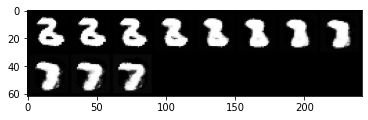

In [ ]:
  class Autoencoder(nn.Module):

      def __init__(self, dim_latent_representation=10):

          super(Autoencoder, self).__init__()

          class Encoder(nn.Module):

              def __init__(self, output_size=10):
                  super(Encoder, self).__init__()
                  input_size = 784
                  hidden_units = 1024
                  self.fc1 = nn.Linear(input_size, hidden_units)
                  self.fc2 = nn.Linear(hidden_units, output_size)

              def forward(self, x):
                  x = x.reshape(x.size(0), -1)
                  x = F.relu(self.fc1(x))
                  return self.fc2(x)

          class Decoder(nn.Module):

              def __init__(self, input_size=10):
                  super(Decoder, self).__init__()
                  output_size = 784
                  hidden_units = 1024
                  self.fc1 = nn.Linear(input_size, hidden_units)
                  self.fc2 = nn.Linear(hidden_units, output_size)

              def forward(self, z):
                  z = F.relu(self.fc1(z))
                  z = F.sigmoid(self.fc2(z))
                  return z.reshape(z.size(0),1,28,28)

          self.encoder = Encoder(output_size=dim_latent_representation)
          self.decoder = Decoder(input_size=dim_latent_representation)

      def forward(self, x):
          x = self.encoder(x)
          x = self.decoder(x)
          return x

# Tuned LEARNING_RATE with values: 1e-5, 1e-4, 1e-3, 1e-2, 1e-1
LEARNING_RATE = 1e-3
# Tuned EPOCH_NUMBER with integers: 1 to 12
EPOCH_NUMBER = 12

autoencoder = Autoencoder(dim_latent_representation=10)
trainer = Autoencoder_Trainer(autoencoder_model=autoencoder, learning_rate=LEARNING_RATE, path=path)

for epoch in range(1, EPOCH_NUMBER + 1):
    trainer.train(epoch)
    trainer.validate(epoch)

images = trainer.get_val_set()

with torch.no_grad():
    images = images.to(trainer.device)
    interpolated_images = None

    for i, t in enumerate(np.linspace(0, 1, 11)):
        encoded = t*autoencoder.encoder(images[0])+(1-t)*autoencoder.encoder(images[1])
        image = autoencoder.decoder(encoded)
        is_first_iteration = i == 0

        if is_first_iteration:
          interpolated_images = image
        else:
          interpolated_images = torch.cat((interpolated_images, image), 0)
    
    reconstructed = trainer.model(interpolated_images).cpu()

print('Reconstructed images')
display_images_in_a_row(reconstructed)

## Morphing images using the (784 x 1024 x 64 x 1024 x 784) Autoencoder

In [ ]:
class Autoencoder(nn.Module):

    def __init__(self, dim_latent_representation=64):

        super(Autoencoder, self).__init__()

        class Encoder(nn.Module):

            def __init__(self, output_size=64):
                super(Encoder, self).__init__()
                input_size = 784
                hidden_units = 1024
                self.fc1 = nn.Linear(input_size, hidden_units)
                self.fc2 = nn.Linear(hidden_units, output_size)

            def forward(self, x):
                x = x.reshape(x.size(0), -1)
                x = F.relu(self.fc1(x))
                return self.fc2(x)

        class Decoder(nn.Module):

            def __init__(self, input_size=64):
                super(Decoder, self).__init__()
                output_size = 784
                hidden_units = 1024
                self.fc1 = nn.Linear(input_size, hidden_units)
                self.fc2 = nn.Linear(hidden_units, output_size)

            def forward(self, z):
                z = F.relu(self.fc1(z))
                z = F.sigmoid(self.fc2(z))
                return z.reshape(z.size(0),1,28,28)

        self.encoder = Encoder(output_size=dim_latent_representation)
        self.decoder = Decoder(input_size=dim_latent_representation)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
# Tuned LEARNING_RATE with values: 1e-5, 1e-4, 1e-3, 1e-2, 1e-1
LEARNING_RATE = 1e-4
# Tuned EPOCH_NUMBER with integers: 1 to 12
EPOCH_NUMBER = 12

autoencoder = Autoencoder(dim_latent_representation=64)
trainer = Autoencoder_Trainer(autoencoder_model=autoencoder, learning_rate=LEARNING_RATE, path=path)

for epoch in range(1, EPOCH_NUMBER + 1):
    trainer.train(epoch)
    trainer.validate(epoch)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0%|          | 0/1875 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 1875/1875 [00:20<00:00, 89.84it/s]

====> Epoch: 1 Average loss: 0.5925



100%|██████████| 313/313 [00:02<00:00, 121.06it/s]

====> Val set loss (reconstruction error) : 0.5389



100%|██████████| 1875/1875 [00:20<00:00, 90.17it/s]

====> Epoch: 2 Average loss: 0.5176



100%|██████████| 313/313 [00:02<00:00, 121.31it/s]

====> Val set loss (reconstruction error) : 0.5169



100%|██████████| 1875/1875 [00:20<00:00, 91.01it/s]


====> Epoch: 3 Average loss: 0.5036


100%|██████████| 313/313 [00:02<00:00, 119.74it/s]

====> Val set loss (reconstruction error) : 0.5078



100%|██████████| 1875/1875 [00:20<00:00, 90.95it/s]

====> Epoch: 4 Average loss: 0.4965



100%|██████████| 313/313 [00:02<00:00, 119.86it/s]

====> Val set loss (reconstruction error) : 0.5018



100%|██████████| 1875/1875 [00:20<00:00, 89.56it/s]

====> Epoch: 5 Average loss: 0.4916



100%|██████████| 313/313 [00:02<00:00, 120.12it/s]

====> Val set loss (reconstruction error) : 0.4978



100%|██████████| 1875/1875 [00:21<00:00, 88.96it/s]

====> Epoch: 6 Average loss: 0.4883



100%|██████████| 313/313 [00:02<00:00, 121.40it/s]

====> Val set loss (reconstruction error) : 0.4950



100%|██████████| 1875/1875 [00:21<00:00, 89.13it/s]

====> Epoch: 7 Average loss: 0.4858



100%|██████████| 313/313 [00:02<00:00, 118.68it/s]

====> Val set loss (reconstruction error) : 0.4927



100%|██████████| 1875/1875 [00:21<00:00, 88.54it/s]

====> Epoch: 8 Average loss: 0.4842



100%|██████████| 313/313 [00:02<00:00, 117.41it/s]

====> Val set loss (reconstruction error) : 0.4915



100%|██████████| 1875/1875 [00:21<00:00, 88.67it/s]

====> Epoch: 9 Average loss: 0.4831



100%|██████████| 313/313 [00:02<00:00, 116.20it/s]

====> Val set loss (reconstruction error) : 0.4906



100%|██████████| 1875/1875 [00:21<00:00, 88.22it/s]

====> Epoch: 10 Average loss: 0.4820



100%|██████████| 313/313 [00:02<00:00, 120.03it/s]

====> Val set loss (reconstruction error) : 0.4895



100%|██████████| 1875/1875 [00:21<00:00, 88.93it/s]

====> Epoch: 11 Average loss: 0.4810



100%|██████████| 313/313 [00:02<00:00, 118.75it/s]

====> Val set loss (reconstruction error) : 0.4886



100%|██████████| 1875/1875 [00:21<00:00, 88.19it/s]

====> Epoch: 12 Average loss: 0.4801



100%|██████████| 313/313 [00:02<00:00, 119.72it/s]

====> Val set loss (reconstruction error) : 0.4880


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Reconstructed images


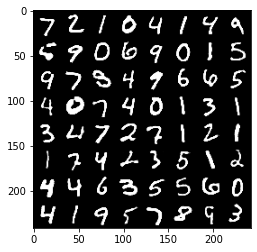

In [ ]:
images = trainer.get_val_set()
total_number = 64
images = images[:total_number]

with torch.no_grad():
    images = images.to(trainer.device)
    reconstructed = trainer.model(images).cpu()

print('Reconstructed images')
display_images_in_a_row(reconstructed)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Reconstructed images


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


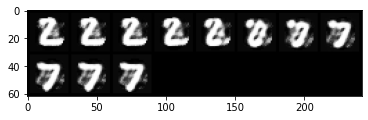

In [ ]:
images = trainer.get_val_set()

with torch.no_grad():
    images = images.to(trainer.device)
    interpolated_images = None

    for i, t in enumerate(np.linspace(0, 1, 11)):
        encoded = t*autoencoder.encoder(images[0])+(1-t)*autoencoder.encoder(images[1])
        image = autoencoder.decoder(encoded)
        is_first_iteration = i == 0

        if is_first_iteration:
          interpolated_images = image
        else:
          interpolated_images = torch.cat((interpolated_images, image), 0)
    
    reconstructed = trainer.model(interpolated_images).cpu()

print('Reconstructed images')
display_images_in_a_row(reconstructed)